# Inflation and Unemployment in the Long Run

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook I replicate the main results from [Berentsen, Menzio and Wright (AER, 2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.1.371) who investigate the long-run relationship between monetary policy and unemployment in the US. 

The authors propose a theoretical model that combines the standard labor search model (Mortensen and Pissarides, 1994) with the standard New Monetarist model (Kyotaki and Wright, 1993; Lagos and Wright, 2005). Monetary policy affects output and employment through the real balance effect: Higher inflation increases the cost of money carried for transaction purposes which lowers consumption, reduces firms' profits from job creation and hence increases unemployment. Matching frictions in the goods market work as an amplification mechanism. Strategic complementarity between buyers' money holdings and firms' entry gives potentially rise to multiple equilibria.

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe

import seaborn as sns  # Better quality figures
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

## Data

We start by importing some data (available on [the paper's webpage at AER](https://www.aeaweb.org/articles?id=10.1257/aer.101.1.371)). This data consists of US quarterly time series over the period 1955-2005 for:
* Money demand (M1/Nominal GDP, annualized)
* Interest rate (AAA corporate bonds, annualized, percent)
* Inflation (annualized, percent)
* Unemployment (percent)

In [2]:
data = pd.read_csv('exportable_data.csv', sep=',', names=['M1/PY', 'unemployment', 'i-AAA', 'inflation'])

data = data.drop(data.index[:28])  # Drop data before 1955

data = data.reset_index(drop=True)  # Reset the index

print(data.count(axis=0))

M1/PY           204
unemployment    204
i-AAA           204
inflation       204
dtype: int64


Some transformations following the authors:

In [3]:
m_data = data['M1/PY']  # Money demand
u_data = data['unemployment'] / 100
p_data = ((1 + (data['inflation'] / 100)) ** (1 / 4)) - 1  # Transform into quarterly series
i_ann_data = data['i-AAA'] / 100
i_data = ((1 + (data['i-AAA'] / 100)) ** (1 / 4)) - 1  # Transform into quarterly rates

Next, we extract the long run component of the data using an HP-filter:

In [4]:
m_cycle, m_trend = sm.tsa.filters.hpfilter(m_data, 1600)
u_cycle, u_trend = sm.tsa.filters.hpfilter(u_data, 1600)
i_cycle, i_trend = sm.tsa.filters.hpfilter(i_data, 1600)
p_cycle, p_trend = sm.tsa.filters.hpfilter(p_data, 1600)

Below, I replicate figure 1 of the paper:

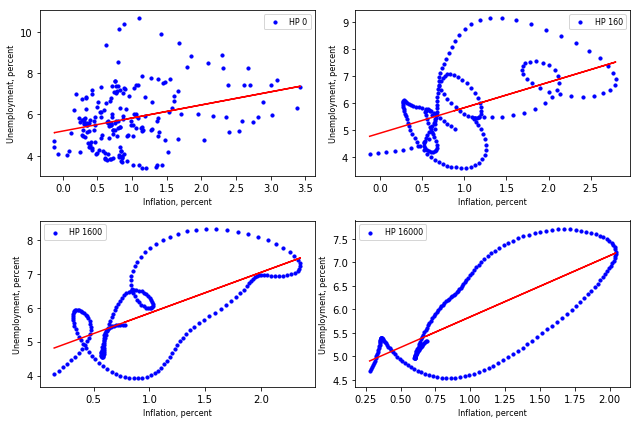

In [5]:
plt.figure(figsize=(9,6))

for k, j in enumerate([0,160,1600,16000]):
    x = sm.tsa.filters.hpfilter(p_data, j)[1]
    y = sm.tsa.filters.hpfilter(u_data, j)[1]

    reg_line = sm.OLS(y, sm.add_constant(x),missing='drop').fit()
    a, b = reg_line.params
    
    plt.subplot(2, 2, k+1)
    plt.plot(x*100, (a + b*x)*100,'r',label='_nolegend_')
    plt.scatter(x*100,y*100,s=10,c='b',label='HP %i' %j)
    plt.legend(loc='best',fontsize=8)
    plt.xlabel('Inflation, percent',fontsize=8)
    plt.ylabel('Unemployment, percent',fontsize=8)
plt.tight_layout()  # creates space between subplots
plt.show()

Next, I compute some moments of the data that will be used later.

In [6]:
m_mean = np.mean(m_data)
i_mean = np.mean(i_data)
p_mean = np.mean(p_data)
u_mean = np.mean(u_data)

print('m_mean =','{:04.2f}'.format(m_mean*100),'%')
print('i_mean =','{:05.2f}'.format(i_mean*100),'%')
print('p_mean =','{:05.2f}'.format(p_mean*100),'%')
print('u_mean =','{:05.2f}'.format(u_mean*100),'%')

m_mean = 17.89 %
i_mean = 01.80 %
p_mean = 00.98 %
u_mean = 05.81 %


I also estimate money demand elasticity based on the annualized unfiltered data using a log-log specification: $\log(m) = \alpha + \beta\log(i)$:

In [7]:
results = sm.OLS(np.log(m_data), sm.add_constant(np.log(data['i-AAA']))).fit()
MDela = results.params[1]
print('Estimated money demand elasticity = ',MDela)

Estimated money demand elasticity =  -0.556520791275344


## Parameters and functional forms

The authors use the following functional forms and parameters:

**Preferences:**
* $u(q)= A \dfrac{q^{1-\alpha}}{1-\alpha}$, the household's utility function for the cash good
* $\beta$, the household's discount factor;
* $b$, the household's productivity at home.

**Technology:**
* $c(q) = G q^\gamma$, the firm's cost of producing the DM good;
* $y$, the firm's production of the general good;
* $k$, the firm's cost from creating a vacancy;
* $\delta$, the job-destruction probability.

**Labor market fricitions:**
* $p(\theta) = \min\{Z \theta^\sigma,1\}$, job-finding probability as a function of the vacancy/unemployment ratio;
* $\eta$, bargaining share of the firm in the wage bargaing;

**Goods market frictions:**
* $m(b/s) = \min\{M (S/B)^\psi,1\}$, seller-finding probability as a function of the seller/buyer ratio;
* $\phi$, bargaining share of the buyer.

I use the same parameter values used by the authors in their base calibration:

In [8]:
A = 1.08
alpha = 0.179
beta = 0.992  # discount factor
delta = 0.05  # exogenous job destruction rate
Z = 0.364  # Parameter of labor market matching function
sigma = 0.28  # Parameter of labor market matching function (Hosios condition used)
eta = 0.28  # wage bargaining power of firm
k = 0.000844  # cost of vacancy posting
G = 1  #
gamma = 1
phi = 1 - 0.725  # bargaining power of buyer
uben = 0.55  # unemployment benefits
leis = 0.50
b = uben + leis  # unemployment flow value (unemployment benefits + leisure)
y = 1  # firm production of the general good

For the functional forms, I use the analytical derivarives as `scipy.misc.derivative` is not yet compatible with `numba`:

In [9]:
@njit
def util(q):
    """
    Utility of consuming q amount of the search good
    """
    
    return A * (q ** (1 - alpha)) / (1 - alpha)


@njit
def dutil(q):
    """
    First derivative of util(q)
    """
    
    return A * q ** (-alpha)


@njit
def ddutil(q):
    """
    Second derivative of util(q)
    """
    
    return (-alpha) * A * q ** (-alpha-1)


@njit
def c(q):
    """
    Cost of producing q amount of the search good
    """
    
    return G * q ** gamma


@njit
def dc(q):
    """
    First derivative of c(q)
    """
    
    return gamma * G * q ** (gamma - 1)


@njit
def ddc(q):
    """
    Second derivative of c(q)
    """
    
    return (gamma - 1) * gamma * G * q ** (gamma - 2)


@njit
def p(theta):
    """
    Job-finding probability as a function of the vacancy/unemployment ratio
    """
    
    return Z * theta ** sigma


@njit
def m(s):
    """
    Seller-finding probability as a function of the seller/buyer ratio
    """
    
    return s / (1 + s)

## Model Steady State

First we implement the steady state version of the model. We start by the goods market optimality conditions.

Using the Nash bargaining solution, we get the price as a function of quantity traded:
    
$$
g(q) = \frac{\phi u'(q) c(q) + (1-\phi) c'(q) u(q)}{\phi u'(q) + (1- \phi) c'(q)}
$$
and solve manually for its derivative (again to be able to use `numba`):
$$
g'(q) = \frac{[u'(q) c'(q) + \phi u''(q) c(q) + (1-\phi) c''(q) u(q)] [\phi u'(q) + (1-\phi)c'(q)] - [\phi u'(q)c(q) + (1-\phi)c'(q)u(q)][\phi u''(q) + (1-\phi)c''(q)]}{[\phi u'(q) + (1- \phi) c'(q)]^2}
$$


The quantity consumed in KW market $q^*$ satisfies the following equilibrium condition (LW curve in the paper):
$$
\frac{u'(q^*)}{g'(q^*)} = 1 + \frac{i}{\mathcal{M}(1,1-u)}
$$
which takes into consideration the opportunity cost of holding money as well as matching frictions.

In [10]:
@njit
def g(q):  
    """
    Pricing function resulting from the Nash bargaining solution
    """
    
    return (phi * dutil(q) * c(q) + (1 - phi) * dc(q) * util(q)) / (phi * dutil(q) + (1 - phi) * dc(q))


@njit
def dg(q):  
    """
    First derivative of g(q)
    """
    
    #d = derivative(g, q, dx=1e-6, n=1)
    
    up, cp = dutil(q), dc(q)
    
    upp, cpp = ddutil(q), ddc(q)
    
    num1 = (up*cp + phi*upp*c(q) + (1-phi)*cpp*util(q)) * (phi*up + (1-phi)*cp)
    
    num2 = (phi*up*c(q) + (1-phi)*cp*util(q)) * (phi*upp + (1-phi)*cpp)
    
    den = (phi*up + (1-phi)*cp) ** 2
    
    d = (num1 - num2) / den

    return d


def q_ss(i, u):  
    """
    Returns the steady state q that satisfies LW curve equation given i and u
    """
    
    lw_curve = lambda q: dutil(q) - (1 + (i / (min(m(1 - u),1)))) * dg(q)
    
    return opt.root(lw_curve, 10 ** (-3), method='lm',options={'ftol': 1e-10}).x

We turn next to the labor market optimality conditions. The job creation condition is given by:

$$
k = \frac{\eta \frac{\mathcal{N}(u,v)}{v} \left(y - b - \ell + \frac{\mathcal{M}(1,1-u)}{1-u}(g(q) - c(q))\right)}{r + \delta + (1-\eta)\frac{\mathcal{N}(u,v)}{u}}
$$

where $v = v(u)$ is pinned down by the steady state condition : $(1-u)\delta = \mathcal{N}(u,v)$ (matches destroyed = matches created).

Let $\theta = \dfrac{v}{u}$ be the labor market tightness. We have then:

$$
\lambda_h = \dfrac{\mathcal{N}(u,v)}{u} = \mathcal{N}(1,\theta) = Z \theta^{\sigma} = p(\theta)
$$ and 
$$
\lambda_f = \dfrac{\mathcal{N}(u,v)}{v} = \mathcal{N}(1/\theta,1) = \dfrac{Z \theta^{\sigma}}{\theta} = \dfrac{p(\theta)}{\theta}
$$

Hence from the steady state condition we have: $\theta_{SS} = \left( \dfrac{(1-u)\delta}{Zu} \right)^{1/\sigma}$

In [11]:
def y_ss(i, u):
    """
    Returns the steady state one period revenues generated by a firm given the state (i,u)
    """
    
    q = q_ss(i,u)
    
    return y + min(m(1 - u) / (1 - u),1) * (g(q) - c(q))


@njit
def theta_ss(u):
    """
    Returns the steady state value of labor market tightness theta as a function of u
    """
    
    return (((1 - u) * delta) / (Z * u)) ** (1 / sigma)


def u_ss(i):
    """
    Returns the steady state level of unemployment that satisfies the beveridge curve for a given i
    """
    
    beveridge_curve = lambda u: k - (min(p(theta_ss(u))/theta_ss(u),1) * eta * (y_ss(i, u) - b)) / (((1 / beta) - 1) + delta + (1 - eta) * min(p(theta_ss(u)),1))
        
    return opt.root(beveridge_curve, 10 ** (-3), method='lm',options={'ftol': 1e-10}).x

### Plotting the Long Run Philips Curve

Next, we compute the LRPC by passing the grid of $i$ to the Beveridge curve and solving for the corresponding steady state $u$:

In [12]:
i_max = max(i_data)
i_min = min(i_data)
i_grid = np.linspace(i_min, i_max, num=204)

x0 = [u_ss(i) for i in i_grid]
x1 = [(i+1)**4-1 for i in i_grid]

and then plot it:

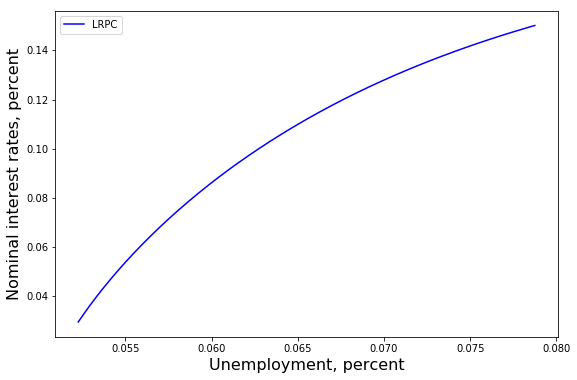

In [13]:
plt.figure(figsize=(9,6))
plt.plot(x0, x1, 'b-', label='LRPC')
plt.xlabel('Unemployment, percent',fontsize=16)
plt.ylabel('Nominal interest rates, percent',fontsize=16)
plt.legend(loc='best')
plt.show()

### Plotting the Money Demand Curve

The money demand relationship in the model is defined as:
$$
\frac{M}{pY} = \frac{M/p}{Y} = \frac{g(q)}{4(1 - u)\left( \alpha_f (g(q) - c(q)) + y \right)}
$$

In [14]:
def MD(i):
    """
    Returns Money Demand as a function of i
    """
    
    u = u_ss(i)
    q = q_ss(i,u)
    
    return g(q) / (4 * (1 - u) * y_ss(i,u))

Which we use to compute model-based money demand as a function of $i$:

In [15]:
x0 = [(i+1)**4-1 for i in i_grid]
x1 = [MD(i) for i in i_grid]

then plot it against the empirical money demand:

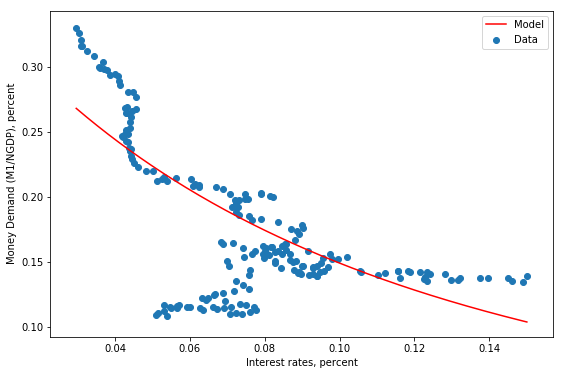

In [16]:
plt.figure(figsize=(9,6))
plt.plot(x0, x1, 'r-', label='Model')
plt.scatter(i_ann_data,m_data, label='Data')
plt.xlabel('Interest rates, percent')
plt.ylabel('Money Demand (M1/NGDP), percent')
plt.legend(loc='best')
plt.show()

As a final check, we calculate the model-based interest rate elasticity of money:

In [17]:
results2 = sm.OLS(np.log(x1), sm.add_constant(np.log(x0))).fit()
MDela_model = results2.params[1]
print('Estimated Money demand elasticity based on model data = ',MDela_model)

Estimated Money demand elasticity based on model data =  -0.6091987292628891


which is close to the value observed in the data (-0.55). This is of course a result of the calibration procedure as explained in the paper.

## Model Dynamics

In order to solve and simulate the model's behavior following a monetary shock, we need to compute the dynamic stochastic soluton. For that we use approximate dynamic programming with a simple value function iteration algorithm.

The state vector is $s = (u, i)$ where $u$ and $i$ follow different laws of motion:

$$
\hat{i} = \bar{i} + \rho_i (i - \bar{i}) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0,\sigma_{\epsilon_i})
\\
\hat{u}(s) = u - u \lambda_h(\theta(s)) + (1 - u)\delta
$$

The timing assumption used here is that information about the state of the economy in the next period is known at the end of the current period (at the end of the AD market). In particular, buyers money holdings and firms vacancy posting at the end of the AD market happen once the monetary shock is realized.

Given the exogenous process of $i$, the recursive equilibrium is formulated as:
* Bellman equation for the match surplus:
$$
S(s) = y - b - \ell + \alpha_f(\frac{1}{1 - \hat{u}(s)}) \left(g(q(s)) - c(q(s))\right) + \beta \mathbb{E}\left[(1 - \delta - (1 - \eta)\lambda_h(\theta(\hat{s})) S(\hat{s})\right]
$$
* LW curve:
$$
1 = \frac{v'(q(s))}{g'(q(s))} - \frac{i}{\alpha_h(\frac{1}{1 - \hat{u}(s)})}
$$
* Free entry condition:
$$
k = \beta \lambda_f(\theta(s))\eta S(s)
$$ 

* LoM for unemployment:
$$
\hat{u}(s) = u - u \lambda_h(\theta(s)) + (1 - u)\delta
$$

We start by setting up the Bellman operator from the Bellman equation above:

In [18]:
def bellman_operator(S):
    """
    Applies the Bellman operator to S and returns the new value function new_S
    """

    new_S = np.empty(S.shape)      #initialize new_S
        
    S = interp.RectBivariateSpline(u_grid,i_grid,S, kx=1, ky=1).ev # Replace S with an interpolated S
    
    def theta(u,i):
                
        sol = (beta * Z * eta * S(u,i) / k) ** (1/(1-sigma))
        
        return sol
    
    # Main loop
    for j_u, u in enumerate(u_grid):
        
        for j_i, i in enumerate(i_grid):
                        
            u_hat = u + (1 - u) * delta - u * min(p(theta(u,i)),1)
                        
            E = np.sum(np.fromiter(((1 - delta - (1 - eta) * min(p(theta(u_hat,i_grid[j_i_hat])),1)) * S(u_hat,i_grid[j_i_hat]) * P[j_i,j_i_hat] for j_i_hat in range(len(i_grid))),float))
                       
            new_S[j_u,j_i] = y_ss(i,u_hat) - b + beta * E
                
    return new_S

As stated above, the nominal interest rate is assumed to follow the process:
$$
\hat{i} = \bar{i} + \rho_i (i - \bar{i}) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0,\sigma_{\epsilon_i})
$$

To calculate the expectation in the RHS of the Bellman operator, we use Tauchen (1986) method to approximate the continuous state AR(1) process by a finite state Markov chain with state space $\{i_0,...,i_{n-1}\}$ and transition matrix $P$:

1. Construct a $n$ points grid (state space) of values for $i$ with the following assigned values:
    * $i_0 = -m \sigma_i$
    * $i_{n-1} = m \sigma_i$
    * $i_j = i_{j-1} + s$ where $s = \dfrac{i_{n-1} + i_0}{n-1}$ where $F$ is the cdf of the normal distribution $\mathcal{N}(0,\sigma_{\epsilon_i})$
2. Assign the following probabilities $P(i_k,i_j)$ to the grid point $i_j$ conditional on $i_k$:
    * For $j = 0$ assign the probability $P(i_k,i_0) = F(i_0 - \bar{i} - \rho_i (i_{k} - \bar{i}) + s /2)$
    * For $j = n-1$ assign the probability $P(i_k,i_{n-1}) = 1 - F(i_{n-1} - \bar{i} - \rho_i (i_{k} - \bar{i}) - s/2)$
    * Otherwise assign the probability $P(i_k,i_j) = F(i_{j} - \bar{i} - \rho_i (i_{k} - \bar{i}) + s/2) - F(i_{j} - \bar{i} - \rho_i (i_{k} - \bar{i}) - s/2)$
    
I implement this method below:

In [19]:
def tauchen(i_acr, i_std, i_mean, m = 3, n = 6):
    """
    Returns the transition matrix and state values of the discrete Markov chain 
    approximation of an AR(1) using Tauchen method
    n : number of states (grid points)
    m : number of standard deviations covered by the grid
    """
    
    x_max = i_mean + m * i_std   
    
    x_min = i_mean - m * i_std
    
    x_grid = np.linspace(x_min, x_max, n)
    
    x_step = (x_max - x_min) / (n - 1)  # step size resulting from the grid

    eps_i_std = i_std * np.sqrt(1 - i_acr ** 2) # STD of the error of the AR(1) process
    
    F = norm(loc=0,scale=eps_i_std).cdf
    
    P = np.empty((n, n))
    
    for k in range(n):
        z = i_mean + i_acr * (x_grid[k] - i_mean) 
        P[k,0] = F(x_grid[0] - z + 0.5 * x_step)
        P[k,n-1] = 1 - F(x_grid[n-1] - z - 0.5 * x_step)
        for j in range(1,n-1):
            P[k,j] = F(x_grid[j] - z + 0.5 * x_step) - F(x_grid[j] - z - 0.5 * x_step)
            
    return P, x_grid

The unconditional variance of the stationary distribution of $i$ is: $ \sigma_i^2 = \dfrac{\sigma_{\epsilon_i}^2}{(1 - \rho_i^2)}$ and $\hat{i}$ conditional on $i$ follows the distribution $\mathcal{N}(\bar{i} + \rho_i (i - \bar{i}),\sigma_{\epsilon_i})$.

Taking $\sigma_i$ and $\rho_i$ from the data, the standard deviation of the process error term is defined as follows:
$$
\sigma_{\epsilon_i} = \sigma_i (1 - \rho_i^2)^{1/2}
$$

In the US data, the quarterly nominal interest rate of AAA bonds has the following moments:

In [20]:
i_mean = np.mean(i_data)
i_acr = sm.tsa.stattools.acf(i_data,unbiased = True, nlags=1)[1]
i_std = np.std(i_data)

print('Average interest rate =','{:05.2f}'.format(i_mean*100),'%')
print('1st order autocorrelation =','{:05.2f}'.format(i_acr*100),'%')
print('Standard deviation =','{:05.2f}'.format(i_std*100),'%')

Average interest rate = 01.80 %
1st order autocorrelation = 98.62 %
Standard deviation = 00.63 %


which we use to get the transition matrix $P$ and a grid for $i$:

In [21]:
P, i_grid = tauchen(i_acr,i_std,i_mean,m=3,n=25)

and then a grid for $u$ as well:

In [22]:
u_max = max(u_data)
u_min = min(u_data)
u_grid = np.linspace(u_min, u_max, num=25)

We also intiatlize the value function using its steady state value:

In [23]:
# Initialize using the steady state value of S
S_ss = (y_ss(i_mean,u_ss(i_mean)) - b) / (1 - beta * (1 - delta - (1 - eta)* min(p(theta_ss(u_ss(i_mean))),1)))

S_init = np.ones((u_grid.size, i_grid.size)) * S_ss  # Initialize S over two dimensions

Finally, we iterate over the Bellman operator until convergence:

In [24]:
S_star = qe.compute_fixed_point(bellman_operator, S_init, error_tol = 1e-15, max_iter = 200)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            2.356e-04      2.140e+00         
10           1.089e-06      4.249e+00         
15           4.509e-09      6.342e+00         
20           1.786e-11      8.420e+00         
25           6.972e-14      1.051e+01         
30           6.314e-16      1.261e+01         
Converged in 30 steps


To check the result, we plot the value function:

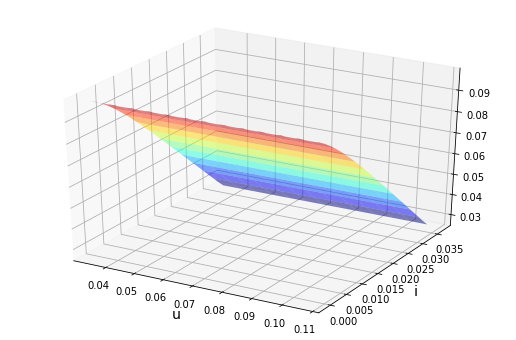

In [25]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ug, ig = np.meshgrid(u_grid, i_grid)
ax.plot_surface(ug,
                ig,
                S_star.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
#ax.set_zlim(, 200)
ax.set_xlabel('u', fontsize=14)
ax.set_ylabel('i', fontsize=14)
plt.show()

### Simulations

Now that we have the optimal value function, we can simulate the model using the historical data. That is, given interest rates from the data and the optimal value function we can compute the model's implied unemployment path.

In [26]:
# First we interpolate the optimal value function
S_star_interp = interp.RectBivariateSpline(u_grid,i_grid,S_star, kx=1, ky=1).ev

# Then we use the interpolated function to compute market tightness
def theta_star(u,i): 
    return (beta * Z * eta * S_star_interp(u,i) / k) ** (1/(1-sigma)) #opt.root(lambda x: k - (beta * min(p(x)/x,1) * eta * S_star_interp(u,i)), 10, method='lm',options={'ftol': 1e-10}).x

# and unemployment
def u_hat(u, theta):
    return u + (1 - u) * delta - u * min(p(theta),1)

u_sim = np.empty(len(u_data))

u_sim[0] = u_data[0] # Initializing u with the first observation in the data

# Computes u_hat based on the previous period computed u and observed i
for jj in range(1,len(u_sim)):
    u_sim[jj] = u_hat(u_sim[jj-1],theta_star(u_sim[jj-1],i_data[jj]))

Using the simulated data we can replicate figure 5:

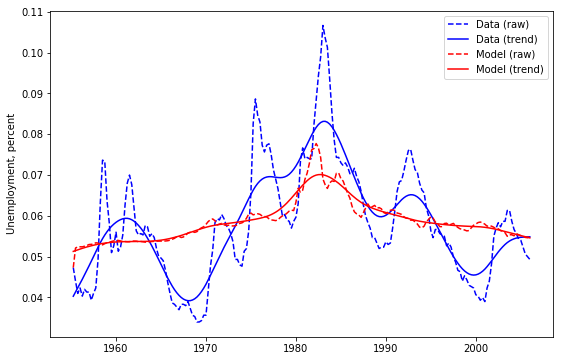

In [27]:
u_sim_cycle, u_sim_trend = sm.tsa.filters.hpfilter(u_sim, 1600)

plt.figure(figsize=(9,6))
dates = pd.date_range(start='1955-01-01',end='2005-12-31',freq='Q')
plt.plot(dates, u_data, 'b--', label='Data (raw)')
plt.plot(dates, u_trend, 'b-', label='Data (trend)')
plt.plot(dates, u_sim, 'r--', label='Model (raw)')
plt.plot(dates, u_sim_trend, 'r-', label='Model (trend)')
#plt.xlim(0.01,0.15)
#plt.ylim(-0.5,2)
plt.ylabel('Unemployment, percent')
plt.legend(loc='best')
plt.show()

and figure 6:

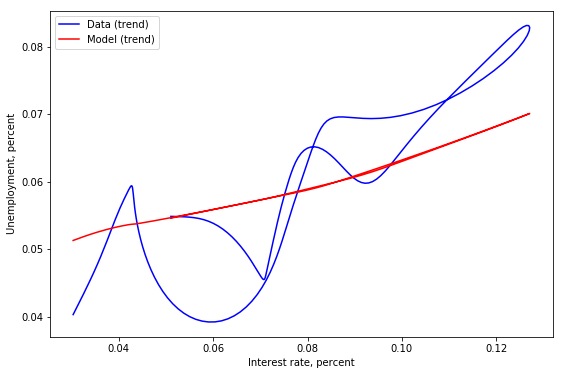

In [28]:
plt.figure(figsize=(9,6))
dates = pd.date_range(start='1955-01-01',end='2005-12-31',freq='Q')
plt.plot((i_trend+1)**4-1, u_trend, 'b-', label='Data (trend)')
plt.plot((i_trend+1)**4-1, u_sim_trend, 'r-', label='Model (trend)')
plt.ylabel('Unemployment, percent')
plt.xlabel('Interest rate, percent')
plt.legend(loc='best')
plt.show()